In [42]:

import time
import scipy.constants as sc
import HERA_hack_FG ##make sure it is in directory



import numpy as np
from scipy import interpolate
import scipy.integrate as integrate
from astropy.cosmology import WMAP9 as cosmo

import scipy.constants as sc
from scipy import signal
from timeit import default_timer as timer
import csv

from astropy import units as u
from astropy.coordinates import Angle
from scipy.interpolate import RectBivariateSpline

import phase_corr_make_universe_3D as uni
import cross_spec_3D
import pspec_3D

import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['ytick.labelsize']=16
plt.rcParams['xtick.labelsize']=16

plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.it'] = 'STIXGeneral:italic'
plt.rcParams['mathtext.bf'] = 'STIXGeneral:italic:bold'
plt.rcParams['mathtext.rm'] = 'STIXGeneral'


%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
data1 = np.loadtxt('/Users/hannahfronenberg/desktop/Grad School/HERA Noise/hera_positions_staged/antenna_positions_37.dat')
hera_bls_core = data1[:,:-1]

data2 = np.loadtxt('/Users/hannahfronenberg/desktop/Grad School/HERA Noise/hera_positions_staged/excess_bls.dat')
hera_bls_outrigger = data2[::5,:-1]

data3 = np.loadtxt('/Users/hannahfronenberg/desktop/Grad School/HERA Noise/hera_positions_staged/antenna_positions_350.dat')
hera_bls_full = data3[:,:-1]

hera_bls = np.vstack((hera_bls_core,hera_bls_outrigger))


npix_row,npix_col = 50,50


pbeam = True 
norm = True 

# acorner = np.array([[120,280],[122,282],[120,282],[122,280]])


acorner = np.array([[119,274],[121,276],[119,276],[121,274]])

HERA = HERA_hack_FG.telescope(hera_bls_full, latitude=-30, channel_width=97800, beam_width=10, beam = 'gaussian')

obs = HERA_hack_FG.observation(telescope = HERA, n_days = 42, freq = 182.54400000000044, delta_t = 0.002 ,corners = acorner, beam_sigma_cutoff=1, sky_shape = (npix_row,npix_col), norm = norm , pbeam = pbeam)


In [12]:

obs.observable_coordinates()
obs.Nbl

16648

In [133]:
obs.compute_general_A(None,None)

In [134]:
obs.invN_general.shape

(3963,)

In [122]:
obs.Abeam * np.exp(obs.Amat_exponentg*(obs.freq*1e6))
print(obs.Abeam.shape)

(3963, 2500)


In [130]:
numThingsToDo = 80
A_rows_per_chunck = int(np.round(obs.Abeam.shape[0]/numThingsToDo))

for i in range(numThingsToDo):
    if i == 0 :
        stop = A_rows_per_chunck
        A_beam_chunck = obs.Abeam[:stop,:]
        print(A_beam_chunck.shape)
    elif i == numThingsToDo-1:
        start = i*A_rows_per_chunck
        A_beam_chunck = obs.Abeam[start:,:]
        print(A_beam_chunck.shape)


    else:
        start = i*A_rows_per_chunck
        stop = (i*A_rows_per_chunck)+A_rows_per_chunck
        A_beam_chunck = obs.Abeam[start:stop,:]
        if i == 3: 
            print(start,stop)
        else:
            pass

    a_file = open("A_beam_%s.txt"%i, "w")
    for row in A_beam_chunck:
        np.savetxt(a_file, row)
    a_file.close() 
    



(50, 2500)
150 200
(13, 2500)


In [138]:
for i in range(numThingsToDo):
    if i == 0 :
        stop = A_rows_per_chunck
        A_exp_chunck = obs.A_exp[:stop,:]
        
    elif i == numThingsToDo-1:
        start = i*A_rows_per_chunck
        A_exp_chunck = obs.A_exp[start:,:]
        
    else:
        start = i*A_rows_per_chunck
        stop = (i*A_rows_per_chunck)+A_rows_per_chunck
        A_exp_chunck = obs.A_exp[start:stop,:]


    a_file = open("A_exp_%s.txt"%i, "w")
    for row in A_exp_chunck:
        np.savetxt(a_file, row.view(float))
    a_file.close() 

In [143]:
path = '/Users/hannahfronenberg/Documents/GitHub/'
assignment = 1

A_exp = np.loadtxt("%sA_matrix/A_exp_%s.txt"%(path,assignment),dtype=np.complex_)#.view(complex).reshape(shape_A) #how to store the shape of chuncks


In [144]:
A_exp

array([0.+4.30107958e-07j, 0.+4.29439890e-07j, 0.+4.28771603e-07j, ...,
       0.+8.91914213e-07j, 0.+8.91025615e-07j, 0.+8.90136565e-07j])

In [136]:
for i in range(numThingsToDo):
    if i == 0 :
        stop = A_rows_per_chunck
        A_exp_chunck = obs.invN_general[:stop]
        print(A_exp_chunck.shape)
        
    elif i == numThingsToDo-1:
        print(i)
        start = i*A_rows_per_chunck
        A_exp_chunck = obs.invN_general[start:]
        print(A_exp_chunck.shape)

    else:
        start = i*A_rows_per_chunck
        stop = (i*A_rows_per_chunck)+A_rows_per_chunck
        A_exp_chunck = obs.invN_general[start:stop]


    a_file = open("N_inv_%s.txt"%i, "w")
    np.savetxt(a_file,A_exp_chunck)
    a_file.close() 


(50,)
79
(13,)


In [24]:
obs.invN_general/(obs.Tsys**2)

array([[1.65204863, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.65204863, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.65204863, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.65204863, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.65204863,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.65204863]])

[177.597 177.694 177.791 177.888 177.985 178.082 178.179 178.276 178.373
 178.47  178.567 178.664 178.761 178.858 178.955 179.052 179.149 179.246
 179.343 179.44  179.537 179.634 179.731 179.828 179.925 180.022 180.119
 180.216 180.313 180.41  180.507 180.604 180.701 180.798 180.895 180.992
 181.089 181.186 181.283 181.38  181.477 181.574 181.671 181.768 181.865
 181.962 182.059 182.156 182.253 182.35  182.447 182.544 182.641 182.738
 182.835 182.932 183.029 183.126 183.223 183.32  183.417 183.514 183.611
 183.708 183.805 183.902 183.999 184.096 184.193 184.29  184.387 184.484
 184.581 184.678 184.775 184.872 184.969 185.066 185.163 185.26  185.357
 185.454 185.551 185.648 185.745 185.842 185.939 186.036 186.133 186.23
 186.327 186.424 186.521 186.618 186.715 186.812 186.909 187.006 187.103
 187.2   187.297 187.394 187.491 187.588 187.685 187.782 187.879 187.976
 188.073 188.17  188.267 188.364 188.461 188.558 188.655 188.752 188.849
 188.946 189.043 189.14  189.237]


In [164]:
freqs = np.arange(1420/(7.5+1),1420/(7+1),0.097)
print(freqs)
freqs = list(np.round(freqs, decimals = 8))
print(freqs)
HI = np.loadtxt("%ssky_sim_50/50_field_21cm_7.24.txt"%'/Users/hannahfronenberg/Documents/GitHub/').reshape((npix_row*npix_col,len(freqs)))
index = freqs.index(freq)%ls
HI = HI[:,index]
print(index)
print(HI)



[167.05882353 167.15582353 167.25282353 167.34982353 167.44682353
 167.54382353 167.64082353 167.73782353 167.83482353 167.93182353
 168.02882353 168.12582353 168.22282353 168.31982353 168.41682353
 168.51382353 168.61082353 168.70782353 168.80482353 168.90182353
 168.99882353 169.09582353 169.19282353 169.28982353 169.38682353
 169.48382353 169.58082353 169.67782353 169.77482353 169.87182353
 169.96882353 170.06582353 170.16282353 170.25982353 170.35682353
 170.45382353 170.55082353 170.64782353 170.74482353 170.84182353
 170.93882353 171.03582353 171.13282353 171.22982353 171.32682353
 171.42382353 171.52082353 171.61782353 171.71482353 171.81182353
 171.90882353 172.00582353 172.10282353 172.19982353 172.29682353
 172.39382353 172.49082353 172.58782353 172.68482353 172.78182353
 172.87882353 172.97582353 173.07282353 173.16982353 173.26682353
 173.36382353 173.46082353 173.55782353 173.65482353 173.75182353
 173.84882353 173.94582353 174.04282353 174.13982353 174.23682353
 174.33382

In [151]:
x = ['p','y','t','h','o','n']
print(x.index('o'))


4


AttributeError: 'list' object has no attribute 'type'

In [153]:
print( list(np.arange(1420/(7.5+1),1420/(7+1),0.097)))
print(np.arange(1420/(7.5+1),1420/(7+1),0.097))

[167.05882352941177, 167.15582352941178, 167.25282352941178, 167.3498235294118, 167.4468235294118, 167.5438235294118, 167.64082352941182, 167.73782352941183, 167.83482352941184, 167.93182352941184, 168.02882352941185, 168.12582352941186, 168.22282352941187, 168.31982352941188, 168.4168235294119, 168.5138235294119, 168.6108235294119, 168.7078235294119, 168.80482352941192, 168.90182352941193, 168.99882352941194, 169.09582352941194, 169.19282352941195, 169.28982352941196, 169.38682352941197, 169.48382352941198, 169.580823529412, 169.677823529412, 169.774823529412, 169.871823529412, 169.96882352941202, 170.06582352941203, 170.16282352941204, 170.25982352941205, 170.35682352941205, 170.45382352941206, 170.55082352941207, 170.64782352941208, 170.7448235294121, 170.8418235294121, 170.9388235294121, 171.0358235294121, 171.13282352941212, 171.22982352941213, 171.32682352941214, 171.42382352941215, 171.52082352941216, 171.61782352941216, 171.71482352941217, 171.81182352941218, 171.9088235294122,

In [5]:


all_chuncks = np.array([chunck_1,chunck_2,chunck_3,chunck_4], dtype = object)

theta_box = Angle(2,u.degree)

z = [624,674,724,774]
z_label_t = [6.24,6.74,7.24,7.74]
z_label = [6.25,6.75,7.25,7.75]
colors  = ['royalblue' ,'darkseagreen','darkorange','darkmagenta']
nbins = 30
nbins_perp = 60

for i in range(4):

    HI = np.loadtxt("/Users/hannahfronenberg/Documents/GitHub/sky_sim_50/50_field_21cm_%s.txt"%z_label_t[i]).reshape((50*50,len(all_chuncks[i])))
    CII = np.loadtxt("/Users/hannahfronenberg/Documents/GitHub/sky_sim_50/50_field_CII_%s.txt"%z_label_t[i]).reshape((50*50,len(all_chuncks[i])))
    
    HI = HI.reshape(50,50,len(all_chuncks[i]))
    CII = CII.reshape(50,50,len(all_chuncks[i]))
    
    cross_spec = cross_spec_3D.Power_Spectrum(HI,CII, theta_box.radian, theta_box.radian,all_chuncks[i],1420,nbins,nbins_perp)
#     cross_spec.compute_1d_from_2d()
    cross_spec.compute_1D_pspec()
    
    pspec_HI = pspec_3D.Power_Spectrum(HI,theta_box.radian, theta_box.radian,all_chuncks[i],1420,nbins,nbins_perp)
    pspec_HI.compute_1D_pspec()
    
    pspec_CII = pspec_3D.Power_Spectrum(CII,theta_box.radian, theta_box.radian,all_chuncks[i],1420,nbins,nbins_perp)
    pspec_CII.compute_1D_pspec()
    
    R = cross_spec.ps_1D/(np.sqrt(pspec_CII.ps_1D*pspec_HI.ps_1D))
    
    
    plt.semilogx(cross_spec.k_modes[1:]/(cosmo.H0.value/100), R, label = "$z = %s$"%z_label[i], color = colors[i])
    plt.semilogx(cross_spec.k_modes[1:]/(cosmo.H0.value/100), R, 'o',color = colors[i])

plt.axhline(y=0, color= 'k', linestyle = '--', linewidth = 1)
plt.xlabel(r'$k$ ($h$ Mpc$^{-1}$)', fontsize= 18)
plt.ylabel(r'r$_{\rm{CII,HI}}(k)$', fontsize= 18)
# plt.title('True Correlations', fontsize = 22 ,y = 1.01)
plt.legend(fontsize = 14)
# plt.xlim(0,1)


OSError: /Users/hannahfronenberg/Documents/GitHub/sky_sim_50/50_field_21cm_6.24.txt not found.

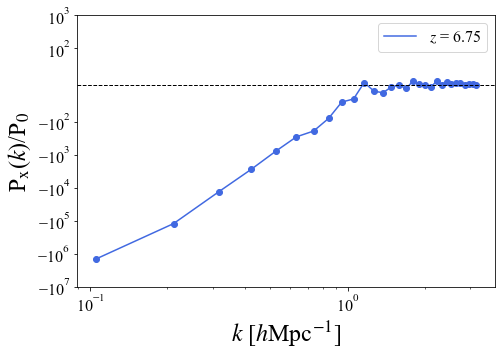

In [31]:
freqs[2]

177.791

In [32]:
#embarassingly parallelize this part

freqs = np.arange(1420/(7+1),1420/(6.5+1),0.097)[1:]

chunck_1 = np.arange(1420/(6.5+1),1420/(6+1),0.097) #central z = 6.25
chunck_2 = np.arange(1420/(7+1),1420/(6.5+1),0.097) #central z = 6.75
chunck_3 = np.arange(1420/(7.5+1),1420/(7+1),0.097) #central z = 7.25
chunck_4 = np.arange(1420/(8+1),1420/(7.5+1),0.097) #central z = 7.75

print(freqs) #these are the freqs that were simulated

freqs = np.array([177.597, 177.694, 177.791, 177.888, 177.985, 178.082, 178.179, 178.276, 178.373,
 178.47,  178.567, 178.664, 178.761, 178.858, 178.955, 179.052, 179.149, 179.246,
 179.343, 179.44,  179.537, 179.634, 179.731, 179.828, 179.925, 180.022, 180.119,
 180.216, 180.313, 180.41,  180.507, 180.604, 180.701, 180.798, 180.895, 180.992,
 181.089, 181.186, 181.283, 181.38,  181.477, 181.574, 181.671, 181.768, 181.865,
 181.962, 182.059, 182.156, 182.253, 182.35,  182.447, 182.544, 182.641, 182.738,
 182.835, 182.932, 183.029, 183.126, 183.223, 183.32,  183.417, 183.514, 183.611,
 183.708, 183.805, 183.902, 183.999, 184.096, 184.193, 184.29,  184.387, 184.484,
 184.581, 184.678, 184.775, 184.872, 184.969, 185.066, 185.163, 185.26,  185.357,
 185.454, 185.551, 185.648, 185.745, 185.842, 185.939, 186.036, 186.133, 186.23,
 186.327, 186.424, 186.521, 186.618, 186.715, 186.812, 186.909, 187.006, 187.103,
 187.2,  187.297,187.394, 187.491, 187.588, 187.685, 187.782, 187.879, 187.976,
 188.073, 188.17,188.267, 188.364, 188.461, 188.558, 188.655, 188.752, 188.849,
 188.946, 189.043, 189.14,  189.237])

HI_mpi = np.zeros((2500,len(freqs)))


for i in range(len(freqs)):
    print(freqs[i])
    raw_map = np.loadtxt('/Users/hannahfronenberg/Documents/GitHub/talk_test/raw_map_%sMHz.txt'%freqs[i],dtype=np.complex_).reshape((2500,))
    norm = np.loadtxt('/Users/hannahfronenberg/Documents/GitHub/talk_test/norm_%sMHz.txt'%freqs[i],dtype=np.complex_).reshape((2500,2500))
    obs_map = np.dot(norm,raw_map)
#     print(obs_map.shape)
    HI_mpi[:,i] = obs_map
    

[177.597 177.694 177.791 177.888 177.985 178.082 178.179 178.276 178.373
 178.47  178.567 178.664 178.761 178.858 178.955 179.052 179.149 179.246
 179.343 179.44  179.537 179.634 179.731 179.828 179.925 180.022 180.119
 180.216 180.313 180.41  180.507 180.604 180.701 180.798 180.895 180.992
 181.089 181.186 181.283 181.38  181.477 181.574 181.671 181.768 181.865
 181.962 182.059 182.156 182.253 182.35  182.447 182.544 182.641 182.738
 182.835 182.932 183.029 183.126 183.223 183.32  183.417 183.514 183.611
 183.708 183.805 183.902 183.999 184.096 184.193 184.29  184.387 184.484
 184.581 184.678 184.775 184.872 184.969 185.066 185.163 185.26  185.357
 185.454 185.551 185.648 185.745 185.842 185.939 186.036 186.133 186.23
 186.327 186.424 186.521 186.618 186.715 186.812 186.909 187.006 187.103
 187.2   187.297 187.394 187.491 187.588 187.685 187.782 187.879 187.976
 188.073 188.17  188.267 188.364 188.461 188.558 188.655 188.752 188.849
 188.946 189.043 189.14  189.237]
177.597
(2500,)
17

/var/folders/rx/h899l7s51ds34rqj_3lmczzh0000gn/T/ipykernel_41799/1075952340.py:34: ComplexWarning: Casting complex values to real discards the imaginary part
  HI_mpi[:,i] = obs_map


(2500,)
177.791
(2500,)
177.888
(2500,)
177.985
(2500,)
178.082
(2500,)
178.179
(2500,)
178.276
(2500,)
178.373
(2500,)
178.47
(2500,)
178.567
(2500,)
178.664
(2500,)
178.761
(2500,)
178.858
(2500,)
178.955
(2500,)
179.052
(2500,)
179.149
(2500,)
179.246
(2500,)
179.343
(2500,)
179.44
(2500,)
179.537
(2500,)
179.634
(2500,)
179.731
(2500,)
179.828
(2500,)
179.925
(2500,)
180.022
(2500,)
180.119
(2500,)
180.216
(2500,)
180.313
(2500,)
180.41
(2500,)
180.507
(2500,)
180.604
(2500,)
180.701
(2500,)
180.798
(2500,)
180.895
(2500,)
180.992
(2500,)
181.089
(2500,)
181.186
(2500,)
181.283
(2500,)
181.38
(2500,)
181.477
(2500,)
181.574
(2500,)
181.671
(2500,)
181.768
(2500,)
181.865
(2500,)
181.962
(2500,)
182.059
(2500,)
182.156
(2500,)
182.253
(2500,)
182.35
(2500,)
182.447
(2500,)
182.544
(2500,)
182.641
(2500,)
182.738
(2500,)
182.835
(2500,)
182.932
(2500,)
183.029
(2500,)
183.126
(2500,)
183.223
(2500,)
183.32
(2500,)
183.417
(2500,)
183.514
(2500,)
183.611
(2500,)
183.708
(2500,)
183.80

OSError: /Users/hannahfronenberg/Documents/GitHub/talk_test/norm_188.267MHz.txt not found.

In [33]:
print(HI_mpi)

[[-5.69282871e+11 -1.25919275e+10  7.48930914e+09 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 7.09432585e+12  9.50591886e+10 -1.74550643e+11 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-4.43461010e+13 -1.52219637e+11  1.65724421e+12 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 3.66875000e+01  3.91015625e+00  1.17285156e+01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.12500000e+00 -2.49804688e+00 -3.66796875e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-6.12890625e+00  4.15771484e-01  2.50488281e-01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


In [210]:
cross_spec_mpi = cross_spec_3D.Power_Spectrum(HI_mpi,CII, theta_box.radian, theta_box.radian,all_chuncks[1],1420,nbins,50)
cross_spec_mpi.compute_1D_pspec()

cross_window_mpi = cross_spec_mpi.ps_1D

In [ ]:
import matplotlib.ticker as mticker


fig, (ax) = plt.subplots(1,1, figsize=(7.5,5), gridspec_kw={'wspace':.2})


    
ax.semilogx(kmodes[1:]/(cosmo.H0.value/100), cross_window, 'o',color = colors[1])
ax.semilogx(kmodes[1:]/(cosmo.H0.value/100),cross_window,label = "old",color = colors[1])

ax.semilogx(kmodes[1:]/(cosmo.H0.value/100), cross_window_mpi, 'o',color = colors[0])
ax.semilogx(kmodes[1:]/(cosmo.H0.value/100),cross_window_mpi,label = "new mpi",color = colors[0])
    
    
ax.set_yscale('symlog',linthresh = 10**2)

sym = mticker.SymmetricalLogLocator(linthresh = 10**2, base=10)
sym.set_params(numticks=6)
ax.yaxis.set_major_locator(sym)


ax.set_ylabel(r'P$_\mathrm{x}$($k$)/P$_0$', fontsize = 24)
ax.set_xlabel(r'$k$ [$h$Mpc$^{-1}$]', fontsize = 24)
ax.axhline(y=0, color= 'k', linestyle = '--', linewidth = 1)
ax.legend(fontsize = 16)
ax.set_ylim(-10**7,10**3)

yticks = ax.yaxis.get_major_ticks()
yticks[-3].set_visible(False)

In [47]:
121//2

60

In [48]:
# pspec_HI = pspec_3D.Power_Spectrum(HI,theta_box.radian, theta_box.radian,all_chuncks[1],1420,nbins,nbins_perp)
# pspec_HI.compute_1D_pspec()

pspec_HI_mpi = pspec_3D.Power_Spectrum(HI_mpi.reshape((50,50,121)),theta_box.radian, theta_box.radian,freqs,1420,nbins,nbins_perp)
pspec_HI_mpi.compute_1D_pspec()




NameError: name 'mticker' is not defined

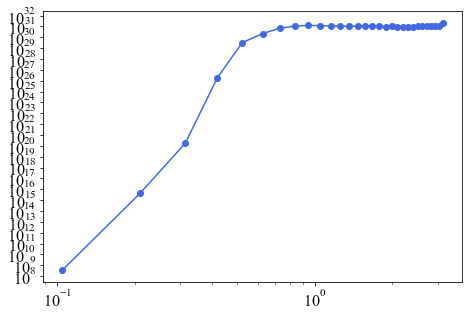

In [52]:
pspec_mpi= pspec_HI_mpi.ps_1D
fig, (ax) = plt.subplots(1,1, figsize=(7.5,5), gridspec_kw={'wspace':.2})


    
ax.semilogx(pspec_HI_mpi.k_modes/(cosmo.H0.value/100), pspec_mpi, 'o',color = colors[0])
ax.semilogx(pspec_HI_mpi.k_modes/(cosmo.H0.value/100),pspec_mpi,label = "new mpi",color = colors[0])
    
    
ax.set_yscale('symlog',linthresh = 10**2)

sym = mticker.SymmetricalLogLocator(linthresh = 10**2, base=10)
sym.set_params(numticks=6)
ax.yaxis.set_major_locator(sym)


ax.set_ylabel(r'P$_\mathrm{x}$($k$)', fontsize = 24)
ax.set_xlabel(r'$k$ [$h$Mpc$^{-1}$]', fontsize = 24)
ax.axhline(y=0, color= 'k', linestyle = '--', linewidth = 1)
ax.legend(fontsize = 16)
# ax.set_ylim(-10**7,10**3)

yticks = ax.yaxis.get_major_ticks()
yticks[-3].set_visible(False)

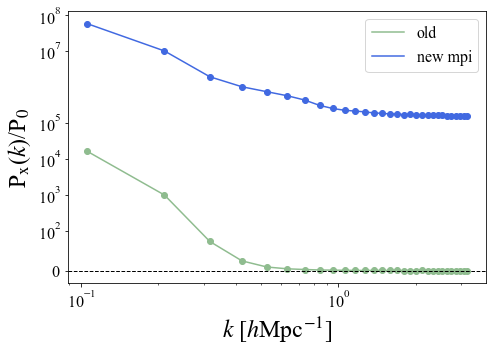

In [230]:
pspec = pspec_HI.ps_1D
pspec_mpi= pspec_HI_mpi.ps_1D
fig, (ax) = plt.subplots(1,1, figsize=(7.5,5), gridspec_kw={'wspace':.2})


    
ax.semilogx(kmodes[1:]/(cosmo.H0.value/100), pspec, 'o',color = colors[1])
ax.semilogx(kmodes[1:]/(cosmo.H0.value/100),pspec,label = "old",color = colors[1])

ax.semilogx(kmodes[1:]/(cosmo.H0.value/100), pspec_mpi, 'o',color = colors[0])
ax.semilogx(kmodes[1:]/(cosmo.H0.value/100),pspec_mpi,label = "new mpi",color = colors[0])
    
    
ax.set_yscale('symlog',linthresh = 10**2)

sym = mticker.SymmetricalLogLocator(linthresh = 10**2, base=10)
sym.set_params(numticks=6)
ax.yaxis.set_major_locator(sym)


ax.set_ylabel(r'P$_\mathrm{x}$($k$)', fontsize = 24)
ax.set_xlabel(r'$k$ [$h$Mpc$^{-1}$]', fontsize = 24)
ax.axhline(y=0, color= 'k', linestyle = '--', linewidth = 1)
ax.legend(fontsize = 16)
# ax.set_ylim(-10**7,10**3)

yticks = ax.yaxis.get_major_ticks()
yticks[-3].set_visible(False)

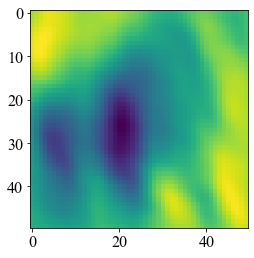

In [223]:
#COMPUTATION IN SERIES
plt.imshow(HI[:,:,0])

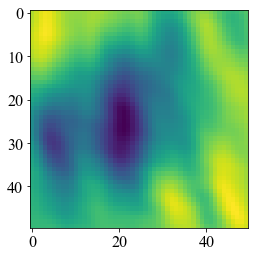

In [58]:
#MPI CORNER TURN MADNESS
plt.imshow(np.real(raw_map))

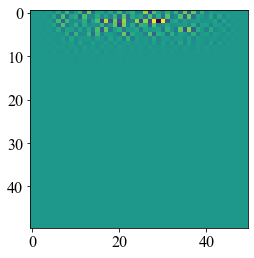

In [35]:
plt.imshow(HI_mpi[:,2].reshape((50,50)))

In [36]:
HI_mpi.shape

(2500, 121)

In [54]:
raw_map = np.zeros((50,50))
for i in range(1):
    raw_map = np.loadtxt('/Users/hannahfronenberg/Documents/GitHub/talk_test/raw_map_%sMHz.txt'%freqs[i],dtype=np.complex_).reshape((50,50))
    

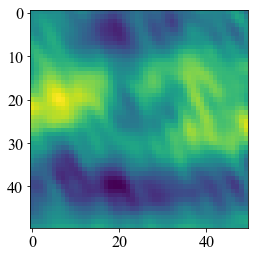

In [56]:
plt.imshow(np.real(raw_map))

In [57]:
raw_map = np.zeros((50,50))
for i in range(1):
    raw_map = np.loadtxt('/Users/hannahfronenberg/Documents/GitHub/talk_test/talk_test'%freqs[i],dtype=np.complex_).reshape((50,50))
    